In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F 
from torch import nn
import sys
sys.path.insert(1, '/Users/leonkiesgen/Documents/Python/BA_Optimization_ML/MaschineLearning/visualisation')
sys.path.insert(1, '/Users/leonkiesgen/Documents/Python/BA_Optimization_ML/MaschineLearning/deeplearningModel')
import json_ImExport
import LogDataImport
import random
import matplotlib.pyplot as plt
import dataprocessing
sys.path.insert(1,"/Users/leonkiesgen/Documents/Python/src/tqdm")

#import torch.utils.tensorboard import SummaryWriter


from tqdm import tqdm
import time

    
if torch.cuda.is_available() and True:
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")    
    
torch.manual_seed(0)

Running on the CPU


## Data Import

In [9]:
with tqdm(total=4) as pbar:
    #Json
    #Jsondata=json_ImExport.loadData("/Users/leonkiesgen/Documents/Python/Kappa_variation_vmax100.json")
    #Log File (Monteblanco)
    pbar.update(1)
    

    Logdata_MB=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_01/15_00_59_data.csv")

    #Log File (Berlin)
    pbar.update(1)
    ValLogdata_B=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_05/12_19_36_data.csv")

    #Log File (Modena)
    pbar.update(1)
    ValLogdata_M=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_05/15_41_27_data.csv")

    #Log File (zalazone)
    pbar.update(1)
    ValLogdata_Z=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_05/15_51_25_data.csv")


100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


## Define NN Model

In [10]:
class RNN(nn.Module):
    def __init__(self,input_size,output_size,hidden_dim,n_layers):
        super(RNN, self).__init__()
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        self.rnn= nn.RNN(input_size,hidden_dim,n_layers,batch_first=True,bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, output_size)
        
        self.calcH = nn.RNN(input_size,hidden_dim,n_layers,batch_first=True,bidirectional=True)
    def forward(self,x,hidden):
        vini=x[:,0,:].squeeze()
        hidden=self.initHidden(x[:,0,:])
        #set_trace()
        r_out,hidden =self.rnn(x[:,1:,:],hidden)
        r_out=r_out.view(-1,2*self.hidden_dim)
        output = self.fc(r_out)

        return output
    
    def initHidden(self,vini):
        
        _,hidden=self.calcH(vini.unsqueeze(0),None)
        return hidden
    
    def zeroHidden(self):
        return torch.zeros(self.n_layers*2,1,self.hidden_dim)

In [11]:
class LSTM(nn.Module):
    def __init__(self,input_size,output_size,hidden_dim,n_layers):
        super(LSTM, self).__init__()
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        self.lstm= nn.LSTM(input_size,hidden_dim,n_layers,batch_first=True,bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, output_size)
        
        #self.calcH = nn.LSTM(input_size,hidden_dim,n_layers,batch_first=True,bidirectional=True)
    def forward(self,x,hidden):
        #vini=x[:,0,:].squeeze()
        #hidden=self.initHidden(x[:,0,:])
        #set_trace()
        r_out,hidden =self.lstm(x,None)
        r_out=r_out.view(-1,2*self.hidden_dim)
        output = self.fc(r_out)

        return output
    
    def initHidden(self,vini):
        
        _,hidden=self.calcH(vini.unsqueeze(0),None)
        return hidden
    
    def zeroHidden(self):
        return torch.zeros(self.n_layers*2,1,self.hidden_dim)

## Data Preperation

In [15]:

model=LSTM(input_size=5,output_size=1,hidden_dim=15,n_layers=1)

traindata=dataprocessing.prepareData([Logdata_MB,ValLogdata_B,ValLogdata_M,ValLogdata_Z],5)

random.shuffle(traindata)
NumSample=len(traindata)
valdata=traindata[int(NumSample*0.7):]
traindata=traindata[:int(NumSample*0.7)-1]

inputT=traindata[3][0].unsqueeze(0)
print(inputT.shape)


h0=model.zeroHidden()
r_out= model(inputT,h0)

print(r_out.squeeze())

70.0
0.001
torch.Size([1, 126, 5])
tensor([ 0.2350,  0.2483,  0.2489,  0.2479,  0.2472,  0.2471,  0.2479,  0.2432,
         0.2309,  0.1961,  0.1595,  0.1578,  0.1570,  0.1608,  0.1749,  0.1885,
         0.1916,  0.1958,  0.1986,  0.1962,  0.1915,  0.1916,  0.1871,  0.1884,
         0.2073,  0.2209,  0.2214,  0.2220,  0.2227,  0.2236,  0.2239,  0.2238,
         0.2231,  0.2269,  0.2415,  0.2507,  0.2505,  0.2536,  0.2585,  0.2833,
         0.3009,  0.3063,  0.3174,  0.3279,  0.3173,  0.3561,  0.1530, -0.1302,
        -0.2700, -0.3758, -0.4427, -0.4721, -0.4966, -0.5262, -0.5165, -0.4927,
        -0.4816, -0.4745, -0.4699, -0.4666, -0.4541, -0.4530, -0.4514, -0.4482,
        -0.4461, -0.4377, -0.4371, -0.4360, -0.4343, -0.4331, -0.4298, -0.4291,
        -0.4289, -0.4292, -0.4293, -0.4300, -0.4299, -0.4280, -0.4245, -0.4215,
        -0.4143, -0.4130, -0.4129, -0.4133, -0.4135, -0.4147, -0.4139, -0.4135,
        -0.4132, -0.4129, -0.4131, -0.4124, -0.4115, -0.4105, -0.4094, -0.4081,
     

In [16]:
from IPython.core.debugger import set_trace

from torch import optim
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model.to(device)
num_epochs = 50

train_tracker, val_tracker, accuracy_tracker = [], [], []


for i in tqdm(range(num_epochs),desc="Total Progress: "):
    
    cum_loss = 0
    random.shuffle(traindata)
    
    for batch,(inp, vel) in enumerate(tqdm(traindata,desc="Training Data"),1):


        inp=inp.unsqueeze(0)
        vel=vel.reshape([1,-1,1])
        inp=inp.to(device)
        
        hidden=model.zeroHidden()
        hidden=hidden.to(device)
        output= model(inp,hidden)

        output=output.view(-1,1)
        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history


        outputVel=torch.reshape(vel,[-1,1])
        outputVel=outputVel.to(device)
        
        loss = criterion(output, outputVel)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cum_loss += loss.item()

    train_tracker.append(cum_loss/len(traindata))
    
    #Validation
    test_loss = 0
    num_correct = 0
    total = 0
    
    random.shuffle(valdata)
    with torch.no_grad():
        for batch, (inp, vel) in enumerate(tqdm(valdata,desc="Valiation Data"),1):
            
            optimizer.zero_grad()
            inp=inp.unsqueeze(0)
            inp=inp.to(device)
            
            output= model(inp,hidden)
            output=output.view(-1,1)
            
            outputVel=torch.reshape(vel,[-1,1])
            outputVel=outputVel.to(device)
            loss = criterion(output, outputVel)
            test_loss += loss

        val_tracker.append(test_loss/len(valdata))
    print(f"Epoch({i+1}/{num_epochs}) | Training loss: {cum_loss/len(traindata)} | " ,end="")
    print(f"Val loss: {test_loss/len(valdata)} | ")


Training Data:   2%|▏         | 95/4588 [00:20<20:28,  3.66it/s]

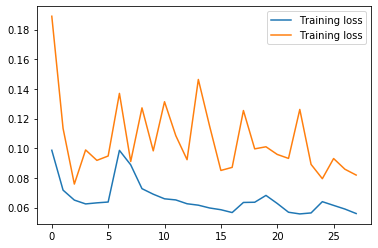

In [48]:
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
plt.plot(val_tracker, label='Training loss')
plt.legend()

In [8]:
def predict(testexample,NN=model):
    VelNormalize= Normalize(None,70)

    criterion = nn.L1Loss()
    #criterion = nn.MSELoss()
    pData=testexample[0]
    pred=NN(pData[0])
    loss=criterion(pred,pData[1])

    %matplotlib inline
    pred=VelNormalize.normal(np.array(pred.tolist()))
    real=VelNormalize.normal(np.array(pData[1]))

    plt.plot(pred,label="Pred")
    plt.plot(real,label= "Real_Optimizer")
    print("Loss:", loss.item())

from sklearn.metrics import r2_score
def Scoring(example,Score='MAE'):
    VelNormalize= Normalize(None,70)
    if Score=='MAE':
        criterion=nn.L1Loss()
    elif Score=="MSE":
        criterion=nn.MSELoss()
    elif Score=="R2":
        return
        PRED=[]
        REAL=[]
        with torch.no_grad():
            for (inp,label) in tqdm(example,leave=False):
                inp=torch.reshape(inp,[-1,1]).unsqueeze(0)
                inp=inp.to(device)
                hidden=model.zeroHidden()
                hidden=hidden.to(device)

                out=model(inp,hidden)

                label=label.to(device)
                out=out.squeeze()

                pred=torch.tensor(np.array(out.tolist()))
                real=torch.tensor(np.array(label.tolist()))

                PRED.append(pred.tolist())
                REAL.append(real.tolist())
        #set_trace()
        return r2_score(PRED,REAL,multioutput='variance_weighted')
    else: 
        print("Loss Function does not exist")
        return
    
    cumloss=0
    
    with torch.no_grad():
        for (inp,label) in tqdm(example,leave=False):

            inp=torch.reshape(inp,[-1,1]).unsqueeze(0)
            inp=inp.to(device)
            hidden=model.zeroHidden()
            hidden=hidden.to(device)
            out=model(inp,hidden)

            label=label.to(device)
            out=out.squeeze()

            pred=torch.tensor(VelNormalize.normal(np.array(out.tolist())))
            real=torch.tensor(VelNormalize.normal(np.array(label.tolist())))

            cumloss += criterion(pred,real)
        
    SCORE=cumloss/len(example)
    
    return SCORE.item()

In [10]:
name="BLSTM_1_15_2_Iter50_MB"
save=False
PATH= "/Users/leonkiesgen/Documents/Python/BA_Optimization_ML/MaschineLearning/mlModels/"+ name

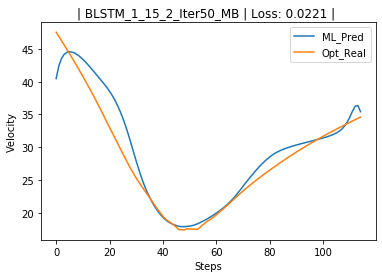

Evolived Time:  38.102149963378906 ms


<function __main__.visual(x)>

In [16]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time


def visual(x):
    #The Visualisation
    NR=x
    
    VelNormalize= Normalize(None,70)
    
    #Loss Functions
    criterion = nn.L1Loss()
    #criterion = nn.MSELoss()
    
    # Data
    testdata_inp,testdata_inp_V,testdata_lable,testdata_lable_V=[],[],[],[]
    
    testdata_inp=torch.clone(traindata[NR][0])
    testdata_inp_V=torch.clone(valdata[NR][0])
    
    testdata_lable=torch.clone(traindata[NR][1])
    testdata_lable_V=torch.clone(valdata[NR][1])
    

    
    #One Example
    inputRNN=torch.reshape(testdata_inp,[-1,1]).unsqueeze(0)
    inputRNN=inputRNN.to(device)
    
    t1=time.time()
    with torch.no_grad():
        hidden=model.zeroHidden()
        hidden=hidden.to(device)
        pred = model(inputRNN,hidden)
    t2=time.time()
    pred=pred.squeeze()
    print("Evolived Time: " , (t2-t1)*1000,"ms")
    testdata_lable=testdata_lable.to(device)
    loss=criterion(pred,testdata_lable)

    %matplotlib inline
    pred=VelNormalize.normal(np.array(pred.tolist()))
    real=VelNormalize.normal(np.array(testdata_lable.tolist()))
    plt.plot(pred,label="Pred")
    plt.plot(real,label= "Real_Optimizer")
    plt.legend(["ML_Pred","Opt_Real"])
    plt.title("| "+name + " | Loss: "+str(np.round(loss.item(),4))+""+ " | " )
    plt.xlabel("Steps")
    plt.ylabel("Velocity")
    
    
    LossEval=False
    if LossEval:
        R2Score_T=Scoring(traindata,"R2")
        print("R2_T: " ,R2Score_T)
        R2Score_V=Scoring(valdata,"R2")
        print("R2_V: " ,R2Score_V)
        
        MAEScore_T=Scoring(traindata,"MAE")
        print("MAE_T: " ,MAEScore_T)
        MAEScore_V=Scoring(valdata,"MAE")
        print("MAE_V: " ,MAEScore_V)
        
        MSEScore_T=Scoring(traindata,"MSE")
        print("MSE_T: " ,MSEScore_T)
        MSEScore_V=Scoring(valdata,"MSE")
        print("MSE_V: " ,MSEScore_V)
        
        
        

    
    
    #scoreItem=r2_score(pred,valdata[NR][1])
    #text= str(np.round(scoreItem,4))+ "% [score] | "+str(np.round(loss.item(),5)) +" [loss] "
    MIN=min(pred)
    #plt.text(76,MIN,text,horizontalalignment='center',verticalalignment='center')
    #print("Loss:", loss.item())
    
    
    #print("The Score of the Train Dataset is: ",Score,"%")
    
interact(visual,x=(0,len(valdata)))

## Save Model

In [37]:
#Save MODEL
if save:
    torch.save(model.state_dict(), PATH+".pt")
    torch.save(model,PATH+".pth")

C:\Users\Leon\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\Leon\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [14]:
#Load MODEL with same Structure
model=LSTM(input_size=1,output_size=1,hidden_dim=15,n_layers=2)
loadPath= "/Users/leonkiesgen/Documents/Python/BA_Optimization_ML/MaschineLearning/mlModels/BLSTM_1_15_2_Iter50_MB.pt"
model.load_state_dict(torch.load(loadPath,map_location=torch.device('cpu')))
model.eval()

LSTM(
  (lstm): LSTM(1, 15, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=30, out_features=1, bias=True)
  (calcH): LSTM(1, 15, num_layers=2, batch_first=True, bidirectional=True)
)

In [ ]:
#Load MODEL with different Structure
model2=torch.load(PATH+".pth")
model2.eval()

In [ ]:
model2(traindata[37][0])